In [83]:
# the discrete case

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 

In [84]:
class encoder(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 5000, out_dim = 200):
        super(encoder, self).__init__()
        self.dim = out_dim
    
        self.fc1 = nn.Linear(input_dim, HIDDEN, bias=True)
        self.ln1 = torch.nn.LayerNorm(HIDDEN)
        self.fc2 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln2 = torch.nn.LayerNorm(HIDDEN)
        self.fc3 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln3 = torch.nn.LayerNorm(HIDDEN)
        self.fc4 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln4 = torch.nn.LayerNorm(HIDDEN)
        self.fc6 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln6 = torch.nn.LayerNorm(HIDDEN)
        self.fc7 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln7 = torch.nn.LayerNorm(HIDDEN)
        self.fc8 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln8 = torch.nn.LayerNorm(HIDDEN)
        self.fc9 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln9 = torch.nn.LayerNorm(HIDDEN)

        self.fc5 = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):

        x = self.ln1(torch.relu((self.fc1(x))))
        x = self.ln2(torch.relu((self.fc2(x))))
        x = self.ln3(torch.relu((self.fc3(x))))
        x = self.ln6(torch.relu((self.fc6(x))))
        x = self.ln7(torch.relu((self.fc7(x))))

        x = torch.sigmoid(self.fc5(x))

        return x

In [211]:
data_matrix = np.load('../investigate_ideas_elbo_entropic_gmm_decoder/celeba_data.npy') 
train_data = data_matrix[:].reshape(-1, 3*28*28) 
train_data = train_data - train_data.min() 
train_data = train_data/train_data.max()

In [212]:
import torch.nn.functional as F

cc = 3
cont = 50
discrete = 5*5

def sample_discrete_class(bs=3000, how_many=5, d_class=5, device='cpu'):
    """
    Samples in [0, d_class-1] then one-hot encodes. Shape: (bs, how_many*d_class).
    """
    # Draw random integers on the chosen device
    discrete_indices = torch.randint(
        low=0, high=d_class, 
        size=(bs * how_many,), 
        device=device
    )
    # One-hot encode and reshape
    discrete = F.one_hot(discrete_indices, num_classes=d_class).float()
    return discrete.view(bs, -1)

def sample_noise(bs=1000, cont_number=cont, num_discrete=20, dim_discrete=20, device='cpu'):
    """
    Combines uniform noise and one-hot discrete noise into a single tensor.
    Shape: (bs, cont_number + num_discrete*dim_discrete).
    """
    # Sample continuous uniform noise on the chosen device
    uniform_noise = torch.rand(bs, cont_number, device=device)
    # Sample discrete (one-hot) noise
    discrete_noise = sample_discrete_class(bs, num_discrete, dim_discrete, device=device)
    # Concatenate along dimension 1
    return torch.cat([uniform_noise, discrete_noise], dim=1)

In [225]:
class encoder(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 500, out_dim = 200):
        super(encoder, self).__init__()
        self.dim = out_dim
    
        self.fc1 = nn.Linear(input_dim, HIDDEN, bias=True)
        self.ln1 = torch.nn.LayerNorm(HIDDEN)
        self.fc2 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln2 = torch.nn.LayerNorm(HIDDEN)
        self.fc3 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln3 = torch.nn.LayerNorm(HIDDEN)
        self.fc4 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln4 = torch.nn.LayerNorm(HIDDEN)
        self.fc6 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln6 = torch.nn.LayerNorm(HIDDEN)
        self.fc7 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln7 = torch.nn.LayerNorm(HIDDEN)
        self.fc8 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln8 = torch.nn.LayerNorm(HIDDEN)
        self.fc9 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln9 = torch.nn.LayerNorm(HIDDEN)

        self.fc5 = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):

        x = self.ln1(torch.relu((self.fc1(x))))
        x = self.ln2(torch.relu((self.fc2(x))))
        x = self.ln3(torch.relu((self.fc3(x))))
#         x = self.ln6(torch.relu((self.fc6(x))))
#         x = self.ln7(torch.relu((self.fc7(x))))

        x = torch.sigmoid(self.fc5(x))

        return x

In [226]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

def adaptive_estimation(v_t, beta, square_term, i):
    v_t = beta*v_t + (1-beta)*square_term.detach()
    return v_t, (v_t/(1-beta**i))

torch.cuda.set_device(0)

def gauss(A,B,var):
    return torch.exp(-((A.unsqueeze(1) - B.unsqueeze(0))**2).mean(2)/(2*var))

torch.manual_seed(1)
np.random.seed(1)

dim = 30
data_dim = 784*3

D = encoder(input_dim = 30, out_dim = data_dim).cuda()

optimizer_D = optim.Adam([
      {'params': D.parameters(), 'lr': 0.0001,'betas': (0.5, 0.9)},
   ])


E = encoder(input_dim = data_dim, out_dim = data_dim).cuda()

optimizer_E = optim.Adam([
      {'params': E.parameters(), 'lr': 0.0001,'betas': (0.5, 0.9)},
   ])


elbo_curve = []
pdf_curve = []
error_curve = []

bound_curve = []
eig_list = []

est_numerator = 0
est_denominator = 0
    
for i in range(1, 200001):
    
    b1 = np.random.choice(train_data.shape[0], 3000)
    batch_data = torch.from_numpy(train_data[b1]).float().cuda()
    bs = batch_data.shape[0]
    
    encoded = torch.zeros((3000, 30)).uniform_().float().cuda()
#     encoded = sample_noise(bs, 50, 10, 10).float().cuda()

    decoded = D(encoded)
    
#     MSE = ((batch_data.unsqueeze(1) - decoded.unsqueeze(0))**2).mean(-1)
# #     gram_matrix = torch.stack([torch.exp(-(MSE/(2*k))) for k in np.linspace(0.01, 0.1, 10)]).mean(0)
#     gram_matrix = torch.exp(-(MSE/(2*1)))
    
#     U, S, V = torch.svd(gram_matrix)
#     cc = -(S[:]).sum()
#     cc.backward()
    
    
#     MSE1 = fast_L2(batch_data, decoded)
#     MSE2 = fast_L2(decoded, decoded)
    
#     numerator = torch.exp(-MSE1/(2*.005)).mean()
#     denominator = torch.exp(-MSE2/(2*.005)).mean()
#     cc = -numerator**2/denominator
#     cc.backward()


    MSE = fast_L2(batch_data, decoded)
    gram_matrix = torch.exp(-MSE/(2*0.1))
    U, S, V = torch.svd(gram_matrix)
    cc = -(S[:]).sum()
    cc.backward()

    
    pdf_curve.append(cc.item())
    
    optimizer_D.step()
    optimizer_D.zero_grad()

    if i % 100 == 0:

        print(i, cc.item())
            
        if i % 500 == 0:
            
#             plt.figure(figsize=(7,7)) 
            save_image(decoded[:].reshape(-1, 3, 28, 28)[:36], 'img1.png', normalize=True, nrow=6, padding=0) 
            img = plt.imread('img1.png') 
            plt.imshow(img) 
            plt.axis('off') 
            plt.show() 

KeyboardInterrupt: 

In [221]:
def fast_L2(batch_data, decoded):
    A = batch_data
    B = decoded
    G = A @ B.T                           # (N, M)
    na = (A * A).sum(dim=1, keepdim=True) # (N, 1) = ||A_i||^2
    nb = (B * B).sum(dim=1, keepdim=True).T  # (1, M) = ||B_j||^2
    d = A.shape[1]
    MSE = (na + nb - 2 * G) / d
    return MSE

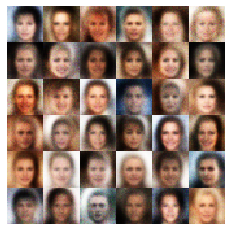

In [223]:
save_image(decoded[:].reshape(-1, 3, 28, 28)[:36], 'img1.png', normalize=True, nrow=6, padding=0) 
img = plt.imread('img1.png') 
plt.imshow(img) 
plt.axis('off') 
plt.show() 

In [175]:
# class encoder(nn.Module):
#     def __init__(self, input_dim = 784, HIDDEN = 500, out_dim = 200):
#         super(encoder, self).__init__()
#         self.dim = out_dim
    
#         self.fc1 = nn.Linear(input_dim+20, HIDDEN, bias=True)
#         self.ln1 = torch.nn.LayerNorm(HIDDEN)
#         self.fc2 = nn.Linear(HIDDEN, HIDDEN, bias=True)
#         self.ln2 = torch.nn.LayerNorm(HIDDEN)
#         self.fc3 = nn.Linear(HIDDEN, HIDDEN, bias=True)
#         self.ln3 = torch.nn.LayerNorm(HIDDEN)
#         self.fc4 = nn.Linear(HIDDEN, HIDDEN, bias=True)
#         self.ln4 = torch.nn.LayerNorm(HIDDEN)
#         self.fc6 = nn.Linear(HIDDEN, HIDDEN, bias=True)
#         self.ln6 = torch.nn.LayerNorm(HIDDEN)
#         self.fc7 = nn.Linear(HIDDEN, HIDDEN, bias=True)
#         self.ln7 = torch.nn.LayerNorm(HIDDEN)
#         self.fc8 = nn.Linear(HIDDEN, HIDDEN, bias=True)
#         self.ln8 = torch.nn.LayerNorm(HIDDEN)
#         self.fc9 = nn.Linear(HIDDEN, HIDDEN, bias=True)
#         self.ln9 = torch.nn.LayerNorm(HIDDEN)

#         self.fc5 = nn.Linear(HIDDEN, out_dim, bias=True)

#     def forward(self, x):
        
#         x = torch.cat((x, torch.zeros((x.shape[0], 20)).uniform_().cuda()), 1)
#         x = self.ln1(torch.relu((self.fc1(x))))
#         x = self.ln2(torch.relu((self.fc2(x))))
# #         x = self.ln3(torch.relu((self.fc3(x))))
# #         x = self.ln6(torch.relu((self.fc6(x))))
# #         x = self.ln7(torch.relu((self.fc7(x))))

#         x = torch.sigmoid(self.fc5(x))

#         return x

In [227]:
class encoder(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 1000, out_dim = 200):
        super(encoder, self).__init__()
        self.dim = out_dim
    
        self.fc1 = nn.Linear(input_dim, HIDDEN, bias=True)
        self.ln1 = torch.nn.LayerNorm(HIDDEN)
        self.fc2 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln2 = torch.nn.LayerNorm(HIDDEN)
        self.fc3 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln3 = torch.nn.LayerNorm(HIDDEN)
        self.fc4 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln4 = torch.nn.LayerNorm(HIDDEN)
        self.fc6 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln6 = torch.nn.LayerNorm(HIDDEN)
        self.fc7 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln7 = torch.nn.LayerNorm(HIDDEN)
        self.fc8 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln8 = torch.nn.LayerNorm(HIDDEN)
        self.fc9 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln9 = torch.nn.LayerNorm(HIDDEN)

        self.fc5 = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):

        x = self.ln1(torch.relu((self.fc1(x))))
        x = self.ln2(torch.relu((self.fc2(x))))
        x = self.ln3(torch.relu((self.fc3(x))))
#         x = self.ln6(torch.relu((self.fc6(x))))
#         x = self.ln7(torch.relu((self.fc7(x))))

        x = torch.sigmoid(self.fc5(x))

        return x

In [293]:
class F_EIG(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 1000, out_dim = 200):
        super(F_EIG, self).__init__()
        self.dim = out_dim
    
        self.fc5 = nn.Linear(input_dim, out_dim, bias=True)

    def forward(self, x):
        
        x = self.fc5(x)
        return x

100 -2896.404296875
200 -2905.1806640625
300 -2907.771484375
400 -2907.5029296875
500 -2908.507568359375


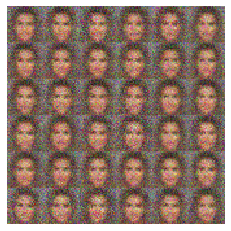

600 -2908.58154296875
700 -2909.63427734375
800 -2910.357421875
900 -2910.2197265625
1000 -2910.44140625


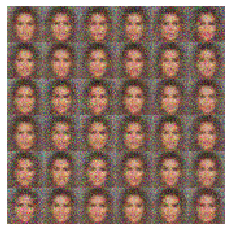

_LinAlgError: linalg.svd: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated singular values (error code: 199).

In [292]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

def adaptive_estimation(v_t, beta, square_term, i):
    v_t = beta*v_t + (1-beta)*square_term.detach()
    return v_t, (v_t/(1-beta**i))

torch.cuda.set_device(0)

def gauss(A,B,var):
    return torch.exp(-((A.unsqueeze(1) - B.unsqueeze(0))**2).mean(2)/(2*var))

torch.manual_seed(1)
np.random.seed(1)

dim = 30
data_dim = 784*3

D = encoder(input_dim = 30, out_dim = data_dim).cuda()

optimizer_D = optim.Adam([
      {'params': D.parameters(), 'lr': 0.00001,'betas': (0.5, 0.9)},
   ])


F = encoder(input_dim = data_dim, out_dim = 200).cuda()

optimizer_F = optim.Adam([
      {'params': F.parameters(), 'lr': 0.00001,'betas': (0.5, 0.9)},
   ])

G = encoder(input_dim = data_dim, out_dim = 200).cuda()

optimizer_G = optim.Adam([
      {'params': G.parameters(), 'lr': 0.00001,'betas': (0.5, 0.9)},
   ])


elbo_curve = []
pdf_curve = []
error_curve = []

bound_curve = []
eig_list = []

est_numerator = 0
est_denominator = 0
    
for i in range(1, 200001):
    
    b1 = np.random.choice(train_data.shape[0], 3000)
    batch_data = torch.from_numpy(train_data[b1]).float().cuda()
    bs = batch_data.shape[0]
    
    encoded = torch.zeros((3000, 30)).uniform_().float().cuda()

    decoded = D(encoded)

    MSE = fast_L2(batch_data, decoded)
    gram_matrix = torch.exp(-MSE/(2*1))
    
    F_OUT = F(batch_data)
    G_OUT = G(decoded)
    
    
    RF, RG, P = F_OUT.T@F_OUT, G_OUT.T@G_OUT, F_OUT.T@G_OUT
    RF = RF + torch.eye(RF.shape[0]).cuda()*1e-3
    RG = RG + torch.eye(RG.shape[0]).cuda()*1e-3
    
    E1,V1 = torch.linalg.eigh(RF)
    RF_NORM = V1@torch.diag(E1**(-1/2))@V1.T

    E2,V2 = torch.linalg.eigh(RG)
    RG_NORM = V2@torch.diag(E2**(-1/2))@V2.T
    
#     U, S, V = torch.svd(RF_NORM@P@RG_NORM)
#     cc = -(S[:]).sum()
#     cc.backward()


    F_NORM = F_OUT@RF_NORM
    G_NORM = G_OUT@RG_NORM
    P = ((F_NORM.T@gram_matrix))@G_NORM
    
    U, S, V = torch.svd(P)
    cc = -(S[:]).sum()
    cc.backward()
    
    pdf_curve.append(cc.item())
    
    optimizer_D.step()
    optimizer_F.step()
    optimizer_G.step()

    optimizer_D.zero_grad()
    optimizer_F.zero_grad()
    optimizer_G.zero_grad()

    if i % 100 == 0:

        print(i, cc.item())
            
        if i % 500 == 0:
            
            save_image(decoded[:].reshape(-1, 3, 28, 28)[:36], 'img1.png', normalize=True, nrow=6, padding=0) 
            img = plt.imread('img1.png') 
            plt.imshow(img) 
            plt.axis('off') 
            plt.show() 

In [288]:
MSE = fast_L2(batch_data, batch_data)
gram_matrix = torch.exp(-MSE/(2*1))

In [289]:
U,S,V = torch.svd(gram_matrix)

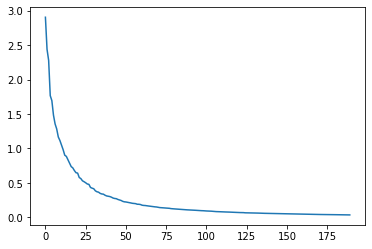

In [290]:
plt.plot(S.detach().cpu()[10:200])

In [286]:
# save_image(decoded[:].reshape(-1, 3, 28, 28)[:36], 'img1.png', normalize=True, nrow=6, padding=0) 
# img = plt.imread('img1.png') 
# plt.imshow(img) 
# plt.axis('off') 
# plt.show() 

In [80]:
D.eval()
with torch.no_grad():
    b1 = np.random.choice(train_data.shape[0], 800)
    batch_data = torch.from_numpy(train_data[b1]).float().cuda()
    bs = batch_data.shape[0]
    
#     encoded = torch.zeros((800, 100)).uniform_().float().cuda()
    encoded = sample_noise(bs, 50, 10, 10).float().cuda()
    decoded = D(encoded)

    
plt.figure(figsize=(7,7)) 
save_image(decoded[:].reshape(-1, 3, 28, 28)[:36], 'img1.png', normalize=True, nrow=6, padding=0) 
img = plt.imread('img1.png') 
plt.imshow(img) 
plt.axis('off') 
plt.show() 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (800x150 and 100x500)

In [52]:
torch.save(D.state_dict(), 'finish_running_D_face.pth')
torch.save(E.state_dict(), 'finish_running_E_face.pth')
torch.save(decoded.detach().cpu(), 'face_decoded_samples')

In [295]:
# the discrete case

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np 

In [296]:
# data_matrix = np.load('../investigate_ideas_elbo_entropic_gmm_decoder/celeba_data.npy') 
# train_data = data_matrix[:40000].reshape(-1, 3*28*28) 
# train_data = train_data - train_data.min() 
# train_data = train_data/train_data.max()

# mnist 

from sklearn.model_selection import train_test_split
from mnist import MNIST
import numpy as np

mndata = MNIST('../MNIST_DEPENDENCE/mnist/MNIST/raw/')
mndata.gz = True

train_data, train_label = mndata.load_training()
test_data, test_label = mndata.load_testing()

train_data = np.array(train_data)
test_data = np.array(test_data)

train_label = np.array(train_label)
test_label = np.array(test_label)

train_data = train_data/255
test_data = test_data/255

argsort = np.argsort(train_label)
train_label = np.take_along_axis(train_label, argsort, axis=0)
train_data = np.take_along_axis(train_data, argsort.reshape(-1, 1), axis=0)

argsort = np.argsort(test_label)
test_label = np.take_along_axis(test_label, argsort, axis=0)
test_data = np.take_along_axis(test_data, argsort.reshape(-1, 1), axis=0)

In [345]:
class encoder(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 1000, out_dim = 200):
        super(encoder, self).__init__()
        self.dim = out_dim
    
        self.fc1 = nn.Linear(input_dim, HIDDEN, bias=True)
        self.ln1 = torch.nn.LayerNorm(HIDDEN)
        self.fc2 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln2 = torch.nn.LayerNorm(HIDDEN)
        self.fc3 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln3 = torch.nn.LayerNorm(HIDDEN)
        self.fc4 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln4 = torch.nn.LayerNorm(HIDDEN)
        self.fc6 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln6 = torch.nn.LayerNorm(HIDDEN)
        self.fc7 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln7 = torch.nn.LayerNorm(HIDDEN)
        self.fc8 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln8 = torch.nn.LayerNorm(HIDDEN)
        self.fc9 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln9 = torch.nn.LayerNorm(HIDDEN)

        self.fc5 = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):

        x = self.ln1(torch.relu((self.fc1(x))))
        x = self.ln2(torch.relu((self.fc2(x))))
        x = self.ln3(torch.relu((self.fc3(x))))
#         x = self.ln6(torch.relu((self.fc6(x))))
#         x = self.ln7(torch.relu((self.fc7(x))))

        x = torch.sigmoid(self.fc5(x))

        return x

In [333]:
class encoder(nn.Module):
    def __init__(self, input_dim = 20, HIDDEN = 3000, out_dim = 784):
        super(encoder, self).__init__()
        self.dim = input_dim
    
        self.fc1 = nn.Linear(self.dim, HIDDEN, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc2 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn2 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc3 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn3 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc4 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn4 = torch.nn.BatchNorm1d(HIDDEN)
        self.fc6 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn6 = torch.nn.BatchNorm1d(HIDDEN)

        self.fc7 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn7 = torch.nn.BatchNorm1d(HIDDEN)
        
        self.fc8 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.bn8 = torch.nn.BatchNorm1d(HIDDEN)

        self.fc5 = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):

        x = self.bn1(torch.relu((self.fc1(x))))
        x = self.bn2(torch.relu((self.fc2(x))))
        x = self.bn3(torch.relu((self.fc3(x))))
        x = self.bn4(torch.relu((self.fc4(x))))
#         x = self.bn6(torch.relu((self.fc6(x))))
#         x = self.bn7(torch.relu((self.fc7(x))))
#         x = self.bn8(torch.relu((self.fc8(x))))

        x = torch.sigmoid(self.fc5(x))

        return x

In [334]:
class F(nn.Module):
    def __init__(self, input_dim = 784, HIDDEN = 500, out_dim = 200):
        super(F, self).__init__()
        self.dim = out_dim
    
        self.fc1 = nn.Linear(input_dim, HIDDEN, bias=True)
        self.ln1 = torch.nn.LayerNorm(HIDDEN)
        self.fc2 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln2 = torch.nn.LayerNorm(HIDDEN)
        self.fc3 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln3 = torch.nn.LayerNorm(HIDDEN)
        self.fc4 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln4 = torch.nn.LayerNorm(HIDDEN)
        self.fc6 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln6 = torch.nn.LayerNorm(HIDDEN)
        self.fc7 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln7 = torch.nn.LayerNorm(HIDDEN)
        self.fc8 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln8 = torch.nn.LayerNorm(HIDDEN)
        self.fc9 = nn.Linear(HIDDEN, HIDDEN, bias=True)
        self.ln9 = torch.nn.LayerNorm(HIDDEN)

        self.fc5 = nn.Linear(HIDDEN, out_dim, bias=True)

    def forward(self, x):

#         x = self.ln1(torch.relu((self.fc1(x))))
#         x = self.ln2(torch.relu((self.fc2(x))))
#         x = self.ln3(torch.relu((self.fc3(x))))
# #         x = self.ln6(torch.relu((self.fc6(x))))
# #         x = self.ln7(torch.relu((self.fc7(x))))

        x = (self.fc5(x))

        return x

100 -987.3530883789062
200 -988.5040283203125
300 -988.76171875
400 -988.806396484375
500 -988.9896240234375
600 -989.0682983398438
700 -989.0595092773438
800 -989.11328125
900 -989.1337890625
1000 -989.03955078125
1100 -989.137939453125
1200 -989.2077026367188
1300 -989.247314453125
1400 -989.129150390625
1500 -989.2254028320312
1600 -989.1661376953125
1700 -989.2323608398438
1800 -989.2858276367188
1900 -989.2732543945312
2000 -989.3564453125
2100 -989.2542114257812
2200 -989.2255859375
2300 -989.2918090820312
2400 -989.31884765625
2500 -989.3246459960938
2600 -989.269775390625
2700 -989.2763061523438
2800 -989.3553466796875
2900 -989.2962036132812
3000 -989.3385620117188
3100 -989.3770141601562
3200 -989.4122314453125
3300 -989.2601318359375
3400 -989.387939453125
3500 -989.2625732421875
3600 -989.3267822265625
3700 -989.37255859375
3800 -989.2791748046875
3900 -989.3441162109375
4000 -989.4083862304688
4100 -989.4150390625
4200 -989.3175048828125
4300 -989.39501953125
4400 -989.374

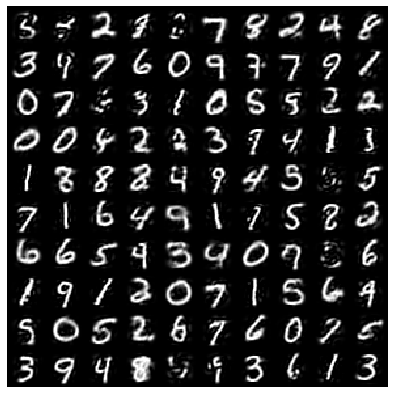

5100 -989.3588256835938
5200 -989.3797607421875
5300 -989.361083984375
5400 -989.392822265625
5500 -989.37841796875
5600 -989.369384765625
5700 -989.4120483398438
5800 -989.3775634765625
5900 -989.3557739257812
6000 -989.376953125
6100 -989.4224243164062
6200 -989.404541015625
6300 -989.4014892578125
6400 -989.3604736328125
6500 -989.4189453125
6600 -989.3154907226562
6700 -989.391845703125
6800 -989.3912963867188
6900 -989.3222045898438
7000 -989.3956909179688
7100 -989.3399658203125
7200 -989.3746337890625
7300 -989.3623046875
7400 -989.508544921875
7500 -989.4197998046875
7600 -989.3751220703125
7700 -989.40283203125
7800 -989.379150390625
7900 -989.4440307617188
8000 -989.4593505859375
8100 -989.4451293945312
8200 -989.4022827148438
8300 -989.4444580078125
8400 -989.3786010742188
8500 -989.437255859375
8600 -989.376708984375
8700 -989.42529296875
8800 -989.4176025390625
8900 -989.412841796875
9000 -989.3592529296875
9100 -989.4318237304688
9200 -989.396484375
9300 -989.401428222656

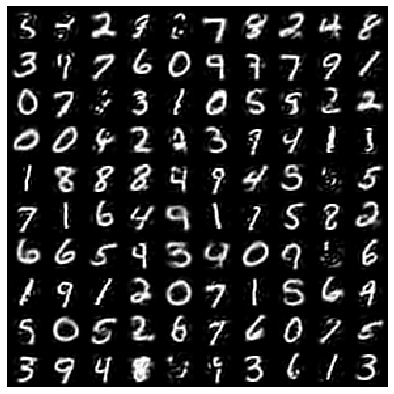

10100 -989.4649047851562
10200 -989.3203735351562
10300 -989.426513671875
10400 -989.50048828125
10500 -989.429931640625
10600 -989.4454956054688
10700 -989.3978881835938
10800 -989.3880615234375
10900 -989.4063720703125
11000 -989.4310302734375
11100 -989.3807373046875
11200 -989.50439453125
11300 -989.45947265625
11400 -989.47021484375
11500 -989.4893188476562
11600 -989.470458984375
11700 -989.408203125
11800 -989.4838256835938
11900 -989.3585205078125
12000 -989.4373168945312
12100 -989.49755859375
12200 -989.4616088867188
12300 -989.4652709960938
12400 -989.384521484375
12500 -989.46435546875
12600 -989.463623046875
12700 -989.4409790039062
12800 -989.4609985351562
12900 -989.4649658203125
13000 -989.4370727539062
13100 -989.4310302734375
13200 -989.4398803710938
13300 -989.4450073242188
13400 -989.4945068359375
13500 -989.49755859375
13600 -989.313720703125
13700 -989.432373046875
13800 -989.5016479492188
13900 -989.370361328125
14000 -989.4136962890625
14100 -989.4478149414062
1

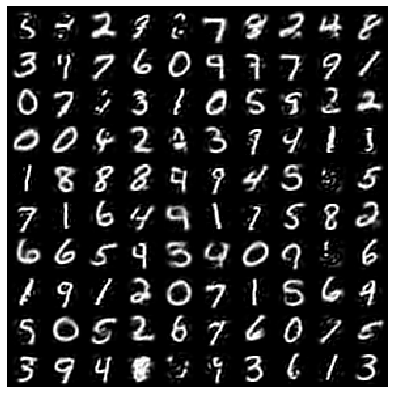

15100 -989.43017578125
15200 -989.4976806640625
15300 -989.4764404296875
15400 -989.4808349609375
15500 -989.4303588867188
15600 -989.468017578125
15700 -989.4453735351562
15800 -989.4176025390625
15900 -989.3457641601562
16000 -989.4197998046875
16100 -989.5262451171875
16200 -989.4436645507812
16300 -989.4661865234375
16400 -989.5164184570312
16500 -989.5390014648438
16600 -989.4281005859375
16700 -989.5045776367188
16800 -989.4696044921875
16900 -989.50341796875
17000 -989.4017333984375
17100 -989.4905395507812
17200 -989.5367431640625
17300 -989.4454345703125
17400 -989.474365234375
17500 -989.4532470703125
17600 -989.4512329101562
17700 -989.4224243164062
17800 -989.4986572265625
17900 -989.4423217773438
18000 -989.3643188476562
18100 -989.3970947265625
18200 -989.5482177734375
18300 -989.4737548828125
18400 -989.528076171875
18500 -989.3991088867188
18600 -989.4541015625
18700 -989.4400024414062
18800 -989.4505615234375
18900 -989.3850708007812
19000 -989.4425048828125
19100 -989

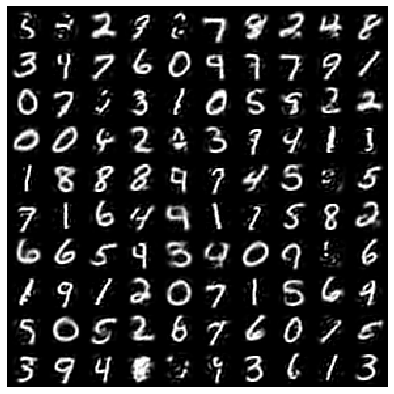

20100 -989.4134521484375
20200 -989.4745483398438
20300 -989.4427490234375
20400 -989.501953125
20500 -989.4595947265625
20600 -989.436767578125
20700 -989.4861450195312
20800 -989.3729248046875
20900 -989.5049438476562
21000 -989.5169067382812
21100 -989.5282592773438
21200 -989.4820556640625
21300 -989.4359130859375
21400 -989.5079345703125
21500 -989.4827880859375
21600 -989.3786010742188
21700 -989.51953125
21800 -989.4973754882812
21900 -989.483642578125
22000 -989.4747924804688
22100 -989.5218505859375
22200 -989.4672241210938
22300 -989.4727172851562
22400 -989.40771484375
22500 -989.5557861328125
22600 -989.5070190429688
22700 -989.4610595703125
22800 -989.4402465820312
22900 -989.4445190429688
23000 -989.5311279296875
23100 -989.462646484375
23200 -989.5660400390625
23300 -989.4970092773438
23400 -989.4501342773438
23500 -989.5199584960938
23600 -989.4976196289062
23700 -989.4389038085938
23800 -989.5234375
23900 -989.4637451171875
24000 -989.529541015625
24100 -989.4445800781

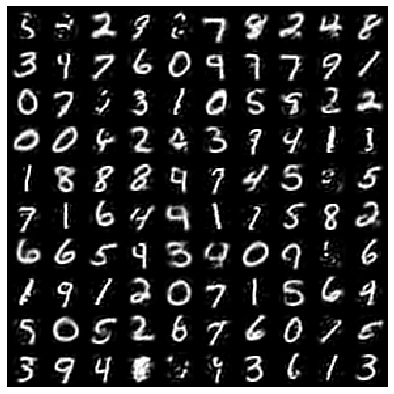

25100 -989.4652099609375
25200 -989.4866333007812
25300 -989.4644165039062
25400 -989.5327758789062
25500 -989.4864501953125
25600 -989.5338745117188
25700 -989.520263671875
25800 -989.4149780273438
25900 -989.3836669921875
26000 -989.448486328125
26100 -989.4828491210938
26200 -989.459716796875
26300 -989.5202026367188
26400 -989.4392700195312
26500 -989.5331420898438
26600 -989.4793701171875
26700 -989.4901123046875
26800 -989.41748046875
26900 -989.4906616210938
27000 -989.460205078125
27100 -989.4993896484375
27200 -989.4434204101562
27300 -989.4000854492188
27400 -989.5914306640625
27500 -989.5296630859375
27600 -989.4840087890625
27700 -989.4617309570312
27800 -989.4698486328125
27900 -989.4718627929688
28000 -989.4513549804688
28100 -989.4410400390625
28200 -989.4640502929688
28300 -989.5349731445312
28400 -989.4498901367188
28500 -989.384521484375
28600 -989.4998779296875
28700 -989.4837036132812
28800 -989.4804077148438
28900 -989.4363403320312
29000 -989.56689453125
29100 -98

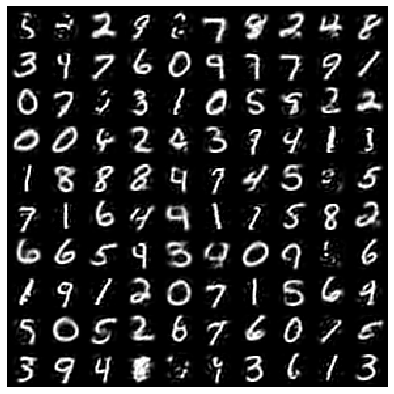

30100 -989.505859375
30200 -989.5084228515625
30300 -989.5121459960938
30400 -989.4581909179688
30500 -989.3969116210938
30600 -989.4464721679688
30700 -989.5322265625
30800 -989.500732421875
30900 -989.471435546875
31000 -989.5008544921875
31100 -989.3689575195312
31200 -989.4840698242188
31300 -989.5518188476562
31400 -989.4507446289062
31500 -989.5506591796875
31600 -989.4588623046875
31700 -989.4371337890625
31800 -989.5283813476562
31900 -989.4434204101562
32000 -989.4725341796875
32100 -989.5037841796875
32200 -989.5457153320312
32300 -989.5621337890625
32400 -989.51171875
32500 -989.522705078125
32600 -989.4992065429688
32700 -989.4089965820312
32800 -989.5083618164062
32900 -989.4327392578125
33000 -989.4845581054688
33100 -989.4069213867188
33200 -989.4349365234375
33300 -989.47265625
33400 -989.5213623046875
33500 -989.5101928710938
33600 -989.5075073242188
33700 -989.4827270507812
33800 -989.5462646484375
33900 -989.4959106445312
34000 -989.4774169921875
34100 -989.471069335

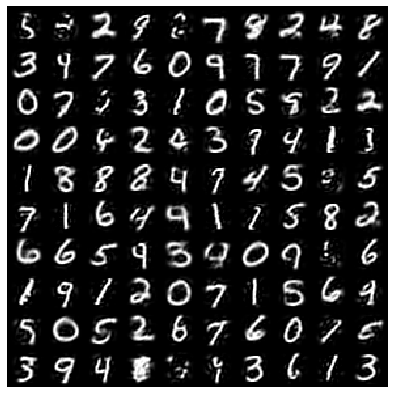

35100 -989.5037841796875
35200 -989.5076293945312
35300 -989.4688720703125
35400 -989.5380249023438
35500 -989.5145263671875
35600 -989.5230712890625
35700 -989.4828491210938
35800 -989.4744873046875
35900 -989.4730834960938
36000 -989.4766235351562
36100 -989.5521850585938
36200 -989.4877319335938
36300 -989.4310913085938
36400 -989.5604248046875
36500 -989.4788208007812
36600 -989.5308227539062
36700 -989.5628662109375
36800 -989.460205078125
36900 -989.491455078125
37000 -989.5520629882812
37100 -989.5582885742188
37200 -989.4677124023438
37300 -989.4718627929688
37400 -989.4749755859375
37500 -989.4639892578125
37600 -989.5178833007812
37700 -989.5140991210938
37800 -989.4796752929688
37900 -989.481201171875
38000 -989.4671630859375
38100 -989.5565795898438
38200 -989.5038452148438
38300 -989.4674682617188
38400 -989.4844360351562
38500 -989.5355224609375
38600 -989.4850463867188
38700 -989.477783203125
38800 -989.489990234375
38900 -989.4183959960938
39000 -989.6245727539062
39100

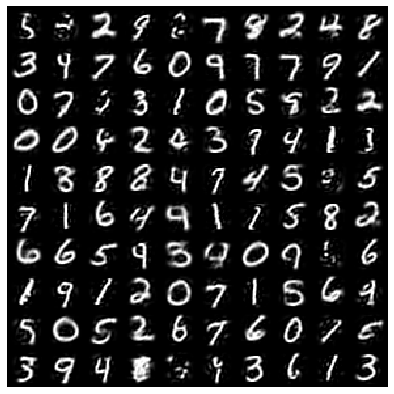

40100 -989.4471435546875
40200 -989.481689453125
40300 -989.5245971679688
40400 -989.5161743164062
40500 -989.471435546875
40600 -989.4844360351562
40700 -989.5205688476562
40800 -989.5427856445312
40900 -989.4239501953125
41000 -989.5608520507812
41100 -989.5620727539062
41200 -989.5475463867188
41300 -989.4517822265625
41400 -989.4524536132812
41500 -989.4630737304688
41600 -989.5355834960938
41700 -989.498291015625
41800 -989.432373046875
41900 -989.45751953125
42000 -989.5018310546875
42100 -989.4716796875
42200 -989.4302978515625
42300 -989.51318359375
42400 -989.4486083984375
42500 -989.5127563476562
42600 -989.4853515625
42700 -989.5311279296875
42800 -989.4362182617188
42900 -989.4854125976562
43000 -989.4737548828125
43100 -989.5634155273438
43200 -989.5691528320312
43300 -989.488037109375
43400 -989.461669921875
43500 -989.4034423828125
43600 -989.6149291992188
43700 -989.505859375
43800 -989.4716796875
43900 -989.5608520507812
44000 -989.4330444335938
44100 -989.539428710937

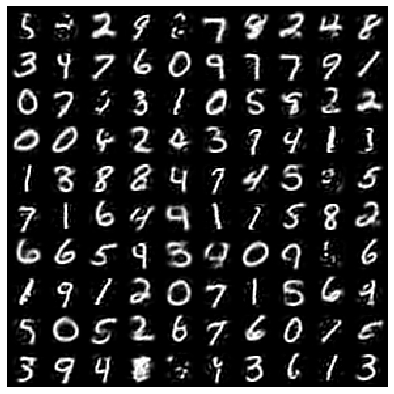

45100 -989.4722290039062
45200 -989.4593505859375
45300 -989.4598388671875
45400 -989.4317016601562
45500 -989.5568237304688
45600 -989.4835815429688
45700 -989.4811401367188
45800 -989.5374755859375
45900 -989.5298461914062
46000 -989.4902954101562
46100 -989.4722900390625
46200 -989.47412109375
46300 -989.54296875
46400 -989.5582885742188
46500 -989.5339965820312
46600 -989.4931030273438
46700 -989.5440673828125
46800 -989.4973754882812
46900 -989.4254760742188
47000 -989.5194702148438
47100 -989.5401611328125
47200 -989.3990478515625
47300 -989.4405517578125
47400 -989.517578125
47500 -989.421142578125
47600 -989.5830078125
47700 -989.564453125
47800 -989.5255737304688
47900 -989.4735717773438
48000 -989.488525390625
48100 -989.4940185546875
48200 -989.4989013671875
48300 -989.5027465820312
48400 -989.5192260742188
48500 -989.4415893554688
48600 -989.4800415039062
48700 -989.4608154296875
48800 -989.5615844726562
48900 -989.53564453125
49000 -989.4805297851562
49100 -989.55047607421

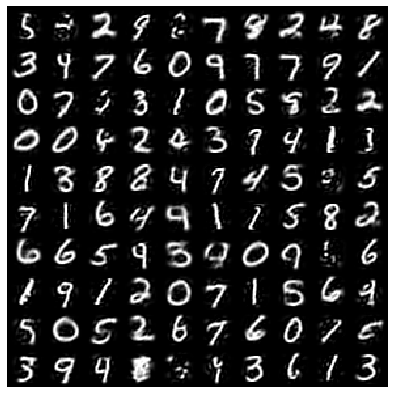

50100 -989.4309692382812
50200 -989.4481201171875
50300 -989.4627685546875
50400 -989.49658203125
50500 -989.552734375
50600 -989.619384765625
50700 -989.4664306640625
50800 -989.4981689453125
50900 -989.47021484375
51000 -989.5526733398438
51100 -989.4727172851562
51200 -989.5133056640625
51300 -989.580810546875
51400 -989.582763671875
51500 -989.5345458984375
51600 -989.4259033203125
51700 -989.5646362304688
51800 -989.490966796875
51900 -989.4232788085938
52000 -989.5181884765625
52100 -989.4578857421875
52200 -989.5009765625
52300 -989.5037841796875
52400 -989.4332275390625
52500 -989.4539184570312
52600 -989.4720458984375
52700 -989.44873046875
52800 -989.4414672851562
52900 -989.5035400390625
53000 -989.5562133789062
53100 -989.5511474609375
53200 -989.48046875
53300 -989.5419921875
53400 -989.427734375
53500 -989.4576416015625
53600 -989.456787109375
53700 -989.5068359375
53800 -989.428955078125
53900 -989.5827026367188
54000 -989.4951171875
54100 -989.5120849609375
54200 -989.5

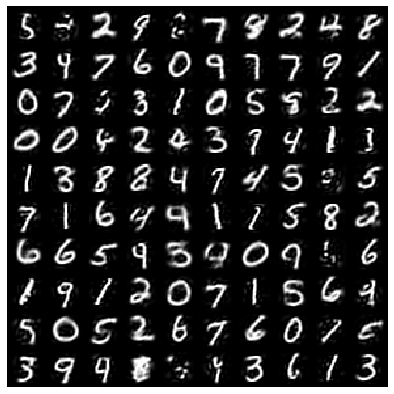

55100 -989.4840698242188
55200 -989.5069580078125
55300 -989.5638427734375
55400 -989.5244140625
55500 -989.5455322265625
55600 -989.4957885742188
55700 -989.5147705078125
55800 -989.5039672851562
55900 -989.4229125976562
56000 -989.4224853515625
56100 -989.5447998046875
56200 -989.4845581054688
56300 -989.5219116210938
56400 -989.6181030273438
56500 -989.5081176757812
56600 -989.5714111328125
56700 -989.4437255859375
56800 -989.5449829101562
56900 -989.4048461914062
57000 -989.51953125
57100 -989.4885864257812
57200 -989.5060424804688
57300 -989.4969482421875
57400 -989.4999389648438
57500 -989.3358154296875
57600 -989.478759765625
57700 -989.4765625
57800 -989.5016479492188
57900 -989.4002685546875
58000 -989.4706420898438
58100 -989.5250244140625
58200 -989.3952026367188
58300 -989.542236328125
58400 -989.4593505859375
58500 -989.4860229492188
58600 -989.49609375
58700 -989.4434204101562
58800 -989.4891967773438
58900 -989.5311889648438
59000 -989.4741821289062
59100 -989.3905639648

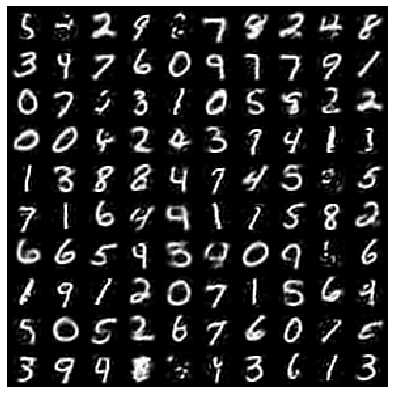

60100 -989.4613037109375
60200 -989.526123046875
60300 -989.5303344726562
60400 -989.49658203125
60500 -989.3973999023438
60600 -989.5663452148438
60700 -989.4049072265625
60800 -989.5873413085938
60900 -989.5257568359375
61000 -989.4901733398438
61100 -989.5372314453125
61200 -989.5347900390625
61300 -989.5802612304688
61400 -989.5901489257812
61500 -989.4495849609375
61600 -989.53515625
61700 -989.4966430664062
61800 -989.49951171875
61900 -989.5348510742188
62000 -989.4802856445312
62100 -989.5316772460938
62200 -989.4825439453125
62300 -989.5692138671875
62400 -989.4807739257812
62500 -989.4684448242188
62600 -989.587890625
62700 -989.560546875
62800 -989.54931640625
62900 -989.5318603515625
63000 -989.50732421875
63100 -989.5420532226562
63200 -989.5223388671875
63300 -989.3978271484375
63400 -989.5223999023438
63500 -989.571044921875
63600 -989.4934692382812
63700 -989.5042114257812
63800 -989.5185546875
63900 -989.5459594726562
64000 -989.4699096679688
64100 -989.5259399414062
6

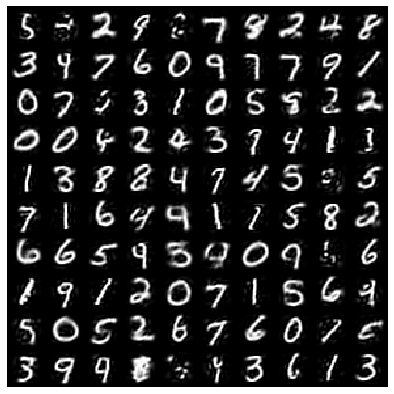

65100 -989.4308471679688
65200 -989.5777587890625
65300 -989.5043334960938
65400 -989.4869384765625
65500 -989.5657958984375
65600 -989.4877319335938
65700 -989.5548095703125
65800 -989.4922485351562
65900 -989.513671875
66000 -989.5215454101562
66100 -989.5660400390625
66200 -989.46484375
66300 -989.4949951171875
66400 -989.537109375
66500 -989.513671875
66600 -989.4815673828125
66700 -989.482666015625
66800 -989.5457763671875
66900 -989.4929809570312
67000 -989.5162353515625
67100 -989.5342407226562
67200 -989.564453125
67300 -989.4995727539062
67400 -989.54443359375
67500 -989.4326171875
67600 -989.5369262695312
67700 -989.4769897460938
67800 -989.5386962890625
67900 -989.5360717773438
68000 -989.5508422851562
68100 -989.520751953125
68200 -989.4935302734375
68300 -989.5416259765625
68400 -989.4642333984375
68500 -989.533447265625
68600 -989.5449829101562
68700 -989.4536743164062
68800 -989.5281372070312
68900 -989.5217895507812
69000 -989.506591796875
69100 -989.4754028320312
69200

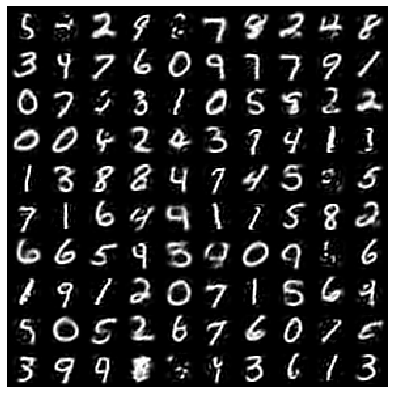

70100 -989.4989013671875
70200 -989.5594482421875
70300 -989.4790649414062
70400 -989.5460205078125
70500 -989.595947265625
70600 -989.5642700195312
70700 -989.5064697265625
70800 -989.4539794921875
70900 -989.3609008789062
71000 -989.5226440429688
71100 -989.5120239257812
71200 -989.54931640625
71300 -989.427978515625
71400 -989.5457763671875
71500 -989.47802734375
71600 -989.5931396484375
71700 -989.5107421875
71800 -989.4722900390625
71900 -989.4519653320312
72000 -989.51220703125
72100 -989.4678955078125
72200 -989.5338745117188
72300 -989.4317016601562
72400 -989.4910888671875
72500 -989.5267944335938
72600 -989.4812622070312
72700 -989.5152587890625
72800 -989.5521240234375
72900 -989.5159912109375
73000 -989.4735717773438
73100 -989.5700073242188
73200 -989.5303344726562
73300 -989.51416015625
73400 -989.5171508789062
73500 -989.5135498046875
73600 -989.4549560546875
73700 -989.5039672851562
73800 -989.5579833984375
73900 -989.4990844726562
74000 -989.518310546875
74100 -989.489

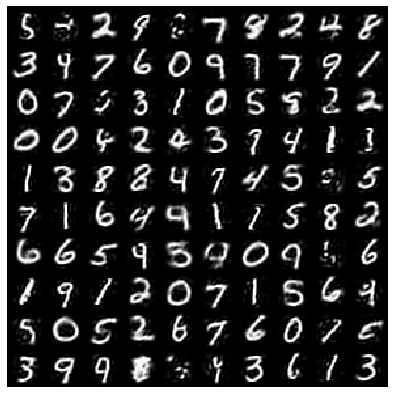

75100 -989.5576171875
75200 -989.485595703125
75300 -989.5176391601562
75400 -989.5336303710938
75500 -989.5390014648438
75600 -989.5430908203125
75700 -989.4818115234375
75800 -989.4470825195312
75900 -989.50830078125
76000 -989.5363159179688
76100 -989.5838012695312
76200 -989.5726318359375
76300 -989.4902954101562
76400 -989.5693969726562
76500 -989.5868530273438
76600 -989.4981689453125
76700 -989.4614868164062
76800 -989.6071166992188
76900 -989.4909057617188
77000 -989.4944458007812
77100 -989.5557250976562
77200 -989.4963989257812
77300 -989.5457153320312
77400 -989.5341796875
77500 -989.5664672851562
77600 -989.5064697265625
77700 -989.4578247070312
77800 -989.5357055664062
77900 -989.5595092773438
78000 -989.5247192382812
78100 -989.44384765625
78200 -989.4954223632812
78300 -989.4949340820312
78400 -989.4412841796875
78500 -989.528076171875
78600 -989.52392578125
78700 -989.451904296875
78800 -989.5059814453125
78900 -989.5799560546875
79000 -989.534423828125
79100 -989.51147

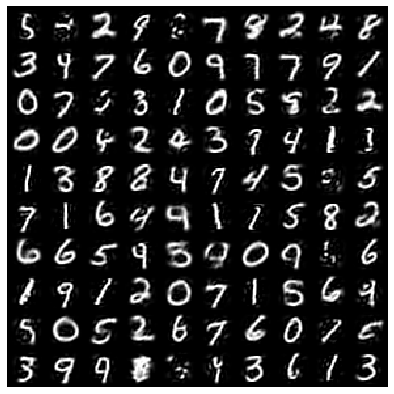

80100 -989.5506591796875
80200 -989.5267333984375
80300 -989.5202026367188
80400 -989.5546875
80500 -989.564208984375
80600 -989.490478515625
80700 -989.4857177734375
80800 -989.5823974609375
80900 -989.5358276367188
81000 -989.5487060546875
81100 -989.5191040039062
81200 -989.5689697265625
81300 -989.5333862304688
81400 -989.540771484375
81500 -989.564208984375
81600 -989.489013671875
81700 -989.4592895507812
81800 -989.5106811523438
81900 -989.5609741210938
82000 -989.4819946289062
82100 -989.5022583007812
82200 -989.6007080078125
82300 -989.50830078125
82400 -989.5617065429688
82500 -989.4086303710938
82600 -989.4605102539062
82700 -989.4990844726562
82800 -989.5592041015625
82900 -989.5181274414062
83000 -989.5336303710938
83100 -989.5438232421875
83200 -989.49951171875
83300 -989.4327392578125
83400 -989.47314453125
83500 -989.4979858398438
83600 -989.6013793945312
83700 -989.5694580078125
83800 -989.4956665039062
83900 -989.5254516601562
84000 -989.5496215820312
84100 -989.426513

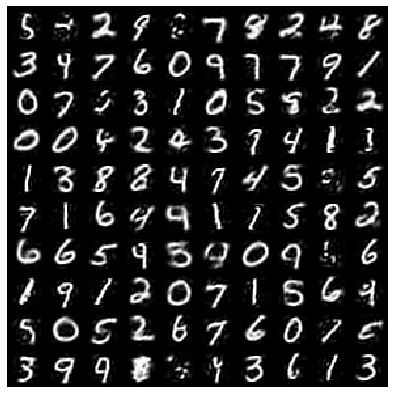

85100 -989.49560546875
85200 -989.46875
85300 -989.5770874023438
85400 -989.5615234375
85500 -989.5140991210938
85600 -989.514404296875
85700 -989.499267578125
85800 -989.5535278320312
85900 -989.5263671875
86000 -989.5444946289062
86100 -989.518310546875
86200 -989.5369262695312
86300 -989.573486328125
86400 -989.5216064453125
86500 -989.50927734375
86600 -989.4860229492188
86700 -989.52490234375
86800 -989.4942626953125
86900 -989.4907836914062
87000 -989.4459228515625
87100 -989.4578857421875
87200 -989.5238037109375
87300 -989.4898071289062
87400 -989.4322509765625
87500 -989.4612426757812
87600 -989.58837890625
87700 -989.5694580078125
87800 -989.528076171875
87900 -989.50244140625
88000 -989.5023193359375
88100 -989.4636840820312
88200 -989.5628662109375
88300 -989.5255126953125
88400 -989.50634765625
88500 -989.4437255859375
88600 -989.481689453125
88700 -989.5017700195312
88800 -989.585693359375
88900 -989.5313110351562
89000 -989.4635009765625
89100 -989.5906372070312
89200 -9

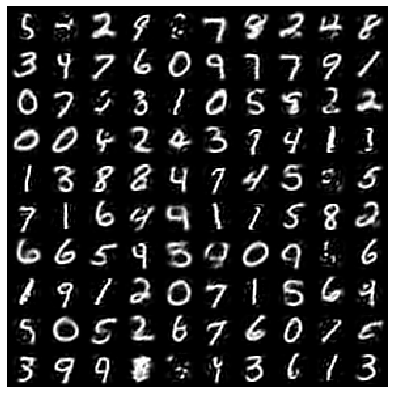

90100 -989.5313110351562
90200 -989.47900390625
90300 -989.5794067382812
90400 -989.5460205078125
90500 -989.5125122070312
90600 -989.5042724609375
90700 -989.4345703125
90800 -989.5902099609375
90900 -989.4159545898438
91000 -989.51123046875
91100 -989.4881591796875
91200 -989.5286254882812
91300 -989.5245361328125
91400 -989.483154296875
91500 -989.5281982421875
91600 -989.4228515625
91700 -989.480224609375
91800 -989.566650390625
91900 -989.5189819335938
92000 -989.5054931640625
92100 -989.5553588867188
92200 -989.488525390625
92300 -989.4570922851562
92400 -989.5045166015625
92500 -989.4632568359375
92600 -989.5745239257812
92700 -989.5203857421875
92800 -989.4940185546875
92900 -989.5247802734375
93000 -989.4639892578125
93100 -989.494873046875
93200 -989.5147705078125
93300 -989.50146484375
93400 -989.5036010742188
93500 -989.51904296875
93600 -989.5176391601562
93700 -989.4660034179688
93800 -989.5068359375
93900 -989.5704345703125
94000 -989.5486450195312
94100 -989.50256347656

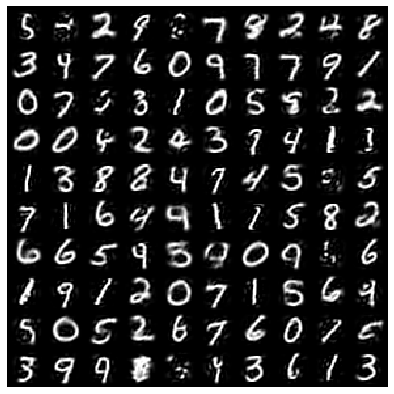

95100 -989.4363403320312
95200 -989.5862426757812
95300 -989.505859375
95400 -989.4723510742188
95500 -989.5366821289062
95600 -989.5160522460938
95700 -989.5443725585938
95800 -989.48193359375
95900 -989.5418090820312
96000 -989.6075439453125
96100 -989.5762329101562
96200 -989.5036010742188
96300 -989.4647827148438
96400 -989.5374145507812
96500 -989.5556030273438
96600 -989.5139770507812
96700 -989.40673828125
96800 -989.4825439453125
96900 -989.6109008789062
97000 -989.4913940429688
97100 -989.5031127929688
97200 -989.4554443359375
97300 -989.4489135742188
97400 -989.5166015625
97500 -989.5042114257812
97600 -989.5193481445312
97700 -989.4927368164062
97800 -989.4528198242188
97900 -989.5028686523438
98000 -989.5076293945312
98100 -989.5106811523438
98200 -989.5107421875
98300 -989.5008544921875
98400 -989.515869140625
98500 -989.5897216796875
98600 -989.556884765625
98700 -989.4915161132812
98800 -989.4569702148438
98900 -989.49755859375
99000 -989.5009155273438
99100 -989.5494384

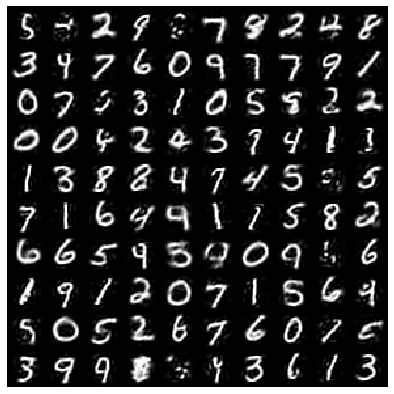

100100 -989.515869140625
100200 -989.5884399414062
100300 -989.5196533203125
100400 -989.4644775390625
100500 -989.5167236328125
100600 -989.5469360351562
100700 -989.5269775390625
100800 -989.5282592773438
100900 -989.5167236328125
101000 -989.50927734375
101100 -989.5701293945312
101200 -989.5515747070312
101300 -989.472900390625
101400 -989.5369873046875
101500 -989.5718383789062
101600 -989.5479125976562
101700 -989.5035400390625
101800 -989.482177734375
101900 -989.5929565429688
102000 -989.5267333984375
102100 -989.4969482421875
102200 -989.4942626953125
102300 -989.5087280273438
102400 -989.5467529296875
102500 -989.4917602539062
102600 -989.4913940429688
102700 -989.4985961914062
102800 -989.464599609375
102900 -989.4990844726562
103000 -989.4639282226562
103100 -989.560546875
103200 -989.5393676757812
103300 -989.5784301757812
103400 -989.5314331054688
103500 -989.509033203125
103600 -989.46875
103700 -989.5277099609375
103800 -989.482666015625
103900 -989.486572265625
104000 

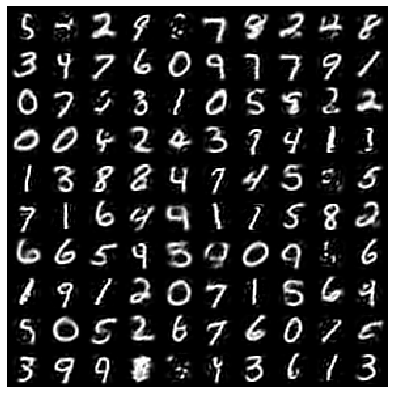

105100 -989.5380249023438
105200 -989.4713745117188
105300 -989.5365600585938
105400 -989.4973754882812
105500 -989.55712890625
105600 -989.5418090820312
105700 -989.534912109375
105800 -989.4747314453125
105900 -989.4951171875
106000 -989.5139770507812
106100 -989.5626220703125
106200 -989.5722045898438
106300 -989.4661865234375
106400 -989.5530395507812
106500 -989.4988403320312
106600 -989.5457153320312
106700 -989.4800415039062
106800 -989.4549560546875
106900 -989.6142578125
107000 -989.5226440429688
107100 -989.501708984375
107200 -989.5339965820312
107300 -989.4427490234375
107400 -989.5119018554688
107500 -989.5147094726562
107600 -989.5689086914062
107700 -989.5210571289062
107800 -989.5
107900 -989.5507202148438
108000 -989.515380859375
108100 -989.4871826171875
108200 -989.4880981445312
108300 -989.5596923828125
108400 -989.55615234375
108500 -989.4959716796875
108600 -989.546875
108700 -989.4660034179688
108800 -989.4627075195312
108900 -989.4985961914062
109000 -989.454040

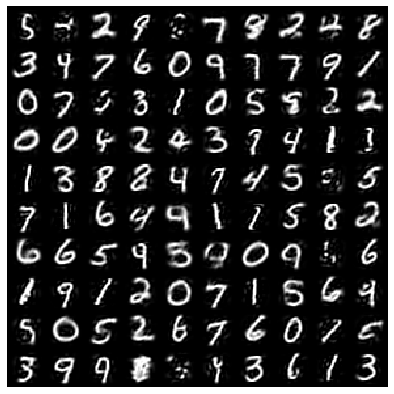

110100 -989.5205078125
110200 -989.56640625
110300 -989.5348510742188
110400 -989.502685546875
110500 -989.5216674804688
110600 -989.509033203125
110700 -989.5773315429688
110800 -989.5614624023438
110900 -989.474609375
111000 -989.5143432617188
111100 -989.5070190429688
111200 -989.4857177734375
111300 -989.5956420898438
111400 -989.5484008789062
111500 -989.4664306640625
111600 -989.4906616210938
111700 -989.4916381835938
111800 -989.5179443359375
111900 -989.494384765625
112000 -989.4498901367188
112100 -989.5811767578125
112200 -989.5186767578125
112300 -989.5114135742188
112400 -989.5713500976562
112500 -989.5570068359375
112600 -989.4886474609375
112700 -989.5386962890625
112800 -989.5027465820312
112900 -989.4713745117188
113000 -989.5255737304688
113100 -989.4974975585938
113200 -989.4827880859375
113300 -989.4551391601562
113400 -989.6486206054688
113500 -989.591064453125
113600 -989.5297241210938
113700 -989.5665893554688
113800 -989.5560302734375
113900 -989.479248046875
114

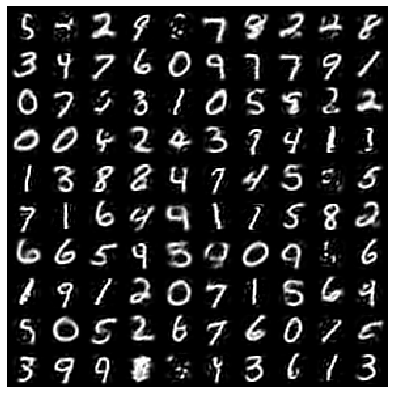

115100 -989.474853515625
115200 -989.4931640625
115300 -989.5287475585938
115400 -989.4600219726562
115500 -989.5191650390625
115600 -989.4668579101562
115700 -989.5404052734375
115800 -989.5245971679688
115900 -989.5301513671875
116000 -989.4844970703125
116100 -989.6415405273438
116200 -989.5751953125
116300 -989.4695434570312
116400 -989.5281372070312
116500 -989.5784912109375
116600 -989.5363159179688
116700 -989.517822265625
116800 -989.4659423828125
116900 -989.4617919921875
117000 -989.4674072265625
117100 -989.5061645507812
117200 -989.49462890625
117300 -989.5797119140625
117400 -989.4989013671875
117500 -989.4983520507812
117600 -989.4818725585938
117700 -989.5385131835938
117800 -989.5719604492188
117900 -989.4308471679688
118000 -989.4895629882812
118100 -989.4454345703125
118200 -989.4776000976562
118300 -989.5193481445312
118400 -989.51904296875
118500 -989.4923706054688
118600 -989.58154296875
118700 -989.4366455078125
118800 -989.5892333984375
118900 -989.4666748046875


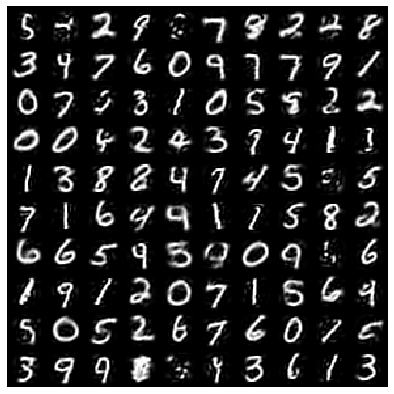

120100 -989.4987182617188
120200 -989.4401245117188
120300 -989.507568359375
120400 -989.5307006835938
120500 -989.5309448242188
120600 -989.3772583007812
120700 -989.4408569335938
120800 -989.4786987304688
120900 -989.492919921875
121000 -989.5072631835938
121100 -989.5510864257812
121200 -989.532958984375
121300 -989.5222778320312
121400 -989.553466796875
121500 -989.5043334960938
121600 -989.496826171875
121700 -989.4451293945312
121800 -989.4772338867188
121900 -989.548828125
122000 -989.4893798828125
122100 -989.5140380859375
122200 -989.4485473632812
122300 -989.5177001953125
122400 -989.5919189453125
122500 -989.5575561523438
122600 -989.5689086914062
122700 -989.518798828125
122800 -989.5697021484375
122900 -989.5482177734375
123000 -989.5382690429688
123100 -989.508544921875
123200 -989.4835205078125
123300 -989.499267578125
123400 -989.4998168945312
123500 -989.4606323242188
123600 -989.606689453125
123700 -989.5576782226562
123800 -989.5494995117188
123900 -989.5283813476562

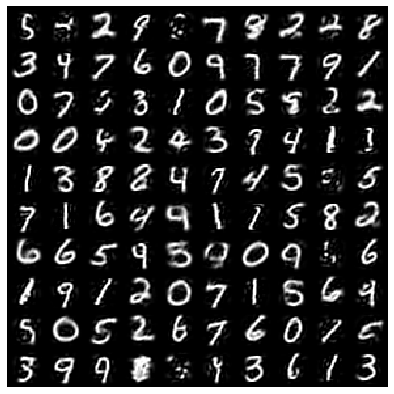

125100 -989.5211791992188
125200 -989.5880737304688
125300 -989.5325927734375
125400 -989.4835205078125
125500 -989.5590209960938
125600 -989.5159912109375
125700 -989.4601440429688
125800 -989.4617919921875
125900 -989.511962890625
126000 -989.4847412109375
126100 -989.5648193359375
126200 -989.43017578125
126300 -989.52490234375
126400 -989.5220947265625
126500 -989.5552368164062
126600 -989.5223388671875
126700 -989.5424194335938
126800 -989.5270385742188
126900 -989.4945678710938
127000 -989.5371704101562
127100 -989.517333984375
127200 -989.5018310546875
127300 -989.509521484375
127400 -989.4664916992188
127500 -989.52392578125
127600 -989.5235595703125
127700 -989.4425659179688
127800 -989.5695190429688
127900 -989.490234375
128000 -989.5144653320312
128100 -989.4869995117188
128200 -989.518310546875
128300 -989.5388793945312
128400 -989.4945068359375
128500 -989.5069580078125
128600 -989.504638671875
128700 -989.5374755859375
128800 -989.487548828125
128900 -989.5234985351562
12

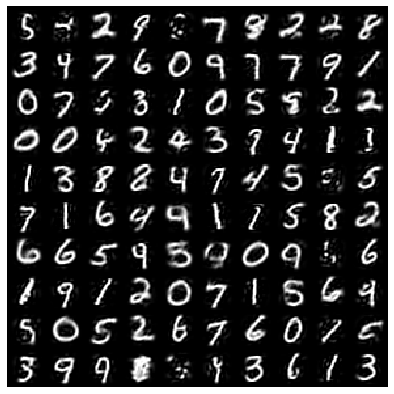

130100 -989.5521240234375
130200 -989.4794921875
130300 -989.4276123046875
130400 -989.5468139648438
130500 -989.5897216796875
130600 -989.4971923828125
130700 -989.4920654296875
130800 -989.50048828125
130900 -989.429931640625
131000 -989.5103759765625
131100 -989.5266723632812
131200 -989.5740966796875
131300 -989.5294189453125
131400 -989.4793090820312
131500 -989.482666015625
131600 -989.5828247070312
131700 -989.4931640625
131800 -989.4488525390625
131900 -989.52001953125
132000 -989.505859375
132100 -989.509765625
132200 -989.534423828125
132300 -989.410400390625
132400 -989.5068359375
132500 -989.621826171875
132600 -989.5125732421875
132700 -989.4798583984375
132800 -989.5738525390625
132900 -989.4683227539062
133000 -989.5479125976562
133100 -989.4732055664062
133200 -989.5100708007812
133300 -989.5493774414062
133400 -989.43359375
133500 -989.5139770507812
133600 -989.5860595703125
133700 -989.5746459960938
133800 -989.55859375
133900 -989.4990234375
134000 -989.561767578125


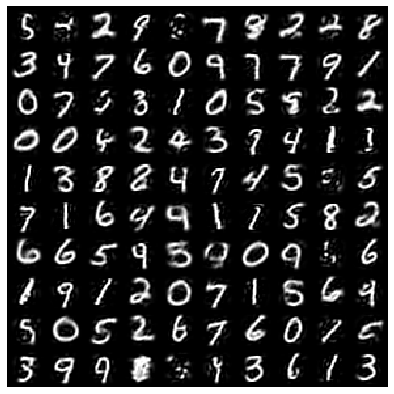

135100 -989.5328979492188
135200 -989.5397338867188
135300 -989.4556884765625
135400 -989.4960327148438
135500 -989.4904174804688
135600 -989.5029296875
135700 -989.5239868164062
135800 -989.5865478515625
135900 -989.4639282226562
136000 -989.5579833984375
136100 -989.4829711914062
136200 -989.4583740234375
136300 -989.4794921875
136400 -989.49560546875
136500 -989.5303344726562
136600 -989.59716796875
136700 -989.610107421875
136800 -989.51318359375
136900 -989.5119018554688
137000 -989.546630859375
137100 -989.5521240234375
137200 -989.4606323242188
137300 -989.5029296875
137400 -989.4395141601562
137500 -989.5173950195312
137600 -989.5374145507812
137700 -989.5831298828125
137800 -989.3809204101562
137900 -989.4906616210938
138000 -989.5106811523438
138100 -989.530029296875
138200 -989.6396484375
138300 -989.521484375
138400 -989.5274047851562
138500 -989.4834594726562
138600 -989.50439453125
138700 -989.5778198242188
138800 -989.4711303710938
138900 -989.4855346679688
139000 -989.5

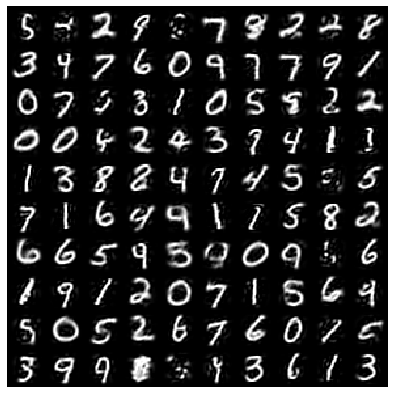

140100 -989.6032104492188
140200 -989.526611328125
140300 -989.4610595703125
140400 -989.5247802734375
140500 -989.5108642578125
140600 -989.543212890625
140700 -989.4793701171875
140800 -989.4738159179688
140900 -989.4602661132812
141000 -989.4315185546875
141100 -989.490478515625
141200 -989.6149291992188
141300 -989.5335693359375
141400 -989.5208740234375
141500 -989.5029296875
141600 -989.5048828125
141700 -989.4920043945312
141800 -989.5648803710938
141900 -989.5115356445312
142000 -989.5804443359375
142100 -989.5737915039062
142200 -989.5635986328125
142300 -989.5045166015625
142400 -989.5371704101562
142500 -989.4664306640625
142600 -989.5336303710938
142700 -989.5409545898438
142800 -989.53271484375
142900 -989.5398559570312
143000 -989.5324096679688
143100 -989.5437622070312
143200 -989.5550537109375
143300 -989.5567626953125
143400 -989.5189819335938
143500 -989.49169921875
143600 -989.5692749023438
143700 -989.4641723632812
143800 -989.4966430664062
143900 -989.5250244140625

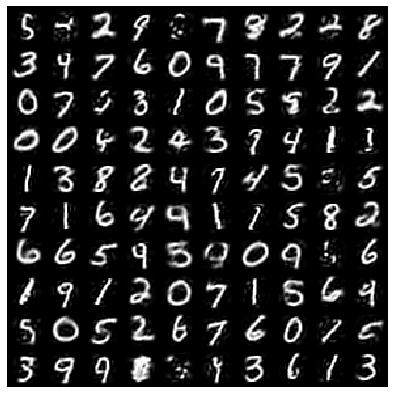

145100 -989.5469970703125
145200 -989.5645751953125
145300 -989.5093383789062
145400 -989.4837036132812
145500 -989.5682983398438
145600 -989.5005493164062
145700 -989.3959350585938
145800 -989.5318603515625
145900 -989.5228881835938
146000 -989.4600219726562
146100 -989.4392700195312
146200 -989.5311889648438
146300 -989.5358276367188
146400 -989.5626220703125
146500 -989.4640502929688
146600 -989.4729614257812
146700 -989.5051879882812
146800 -989.4885864257812
146900 -989.510986328125
147000 -989.6239624023438
147100 -989.4973754882812
147200 -989.4668579101562
147300 -989.5385131835938
147400 -989.5147094726562
147500 -989.459228515625
147600 -989.53076171875
147700 -989.52099609375
147800 -989.4739379882812
147900 -989.4743041992188
148000 -989.528564453125
148100 -989.4813232421875
148200 -989.5822143554688
148300 -989.4927978515625
148400 -989.5291137695312
148500 -989.5206909179688
148600 -989.5154418945312
148700 -989.4939575195312
148800 -989.477294921875
148900 -989.56823730

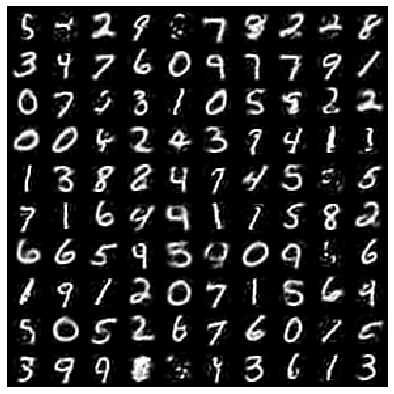

150100 -989.5029907226562
150200 -989.5448608398438
150300 -989.5875244140625
150400 -989.5482788085938
150500 -989.5391235351562
150600 -989.49365234375
150700 -989.47607421875
150800 -989.5687866210938
150900 -989.575927734375
151000 -989.5681762695312
151100 -989.559326171875
151200 -989.504638671875
151300 -989.51318359375
151400 -989.4591064453125
151500 -989.531982421875
151600 -989.5181884765625
151700 -989.5364379882812
151800 -989.57080078125
151900 -989.5549926757812
152000 -989.479736328125
152100 -989.5681762695312
152200 -989.4812622070312
152300 -989.4860229492188
152400 -989.4677124023438
152500 -989.5000610351562
152600 -989.458740234375
152700 -989.533935546875
152800 -989.4987182617188
152900 -989.5516967773438
153000 -989.5383911132812
153100 -989.4938354492188
153200 -989.44189453125
153300 -989.5482788085938
153400 -989.5234375
153500 -989.5087890625
153600 -989.561767578125
153700 -989.5269165039062
153800 -989.5106811523438
153900 -989.5573120117188
154000 -989.5

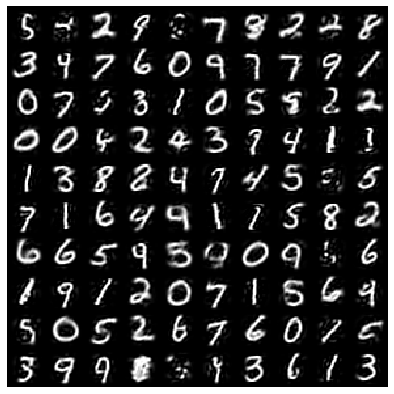

155100 -989.4992065429688
155200 -989.5068969726562
155300 -989.5609741210938
155400 -989.518310546875
155500 -989.5120849609375
155600 -989.5205688476562
155700 -989.6116943359375
155800 -989.513427734375
155900 -989.50927734375
156000 -989.50244140625
156100 -989.5621948242188
156200 -989.4884033203125
156300 -989.4415283203125
156400 -989.5422973632812
156500 -989.48193359375
156600 -989.4100952148438
156700 -989.5286254882812
156800 -989.5457153320312
156900 -989.4673461914062
157000 -989.4390258789062
157100 -989.4945678710938
157200 -989.494140625
157300 -989.5467529296875
157400 -989.5076904296875
157500 -989.472900390625
157600 -989.4862670898438
157700 -989.39697265625
157800 -989.4862060546875
157900 -989.4636840820312
158000 -989.5128784179688
158100 -989.4949340820312
158200 -989.5040893554688
158300 -989.5272827148438
158400 -989.5078735351562
158500 -989.5086669921875
158600 -989.5230102539062
158700 -989.609375
158800 -989.593017578125
158900 -989.47216796875
159000 -989

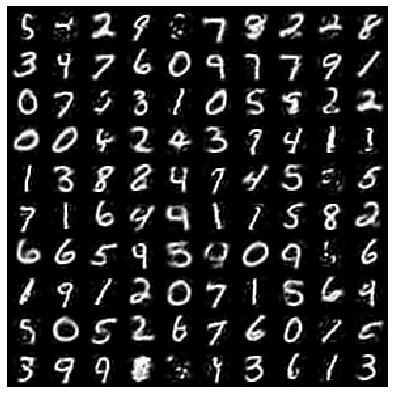

160100 -989.5560913085938
160200 -989.5712280273438
160300 -989.5516967773438
160400 -989.5400390625
160500 -989.5457763671875
160600 -989.4761962890625
160700 -989.4727172851562
160800 -989.594482421875
160900 -989.4037475585938
161000 -989.5543823242188
161100 -989.5414428710938
161200 -989.579345703125
161300 -989.4944458007812
161400 -989.4181518554688
161500 -989.4682006835938
161600 -989.43408203125
161700 -989.5359497070312
161800 -989.5337524414062
161900 -989.4496459960938
162000 -989.4620971679688
162100 -989.5430297851562
162200 -989.5372314453125
162300 -989.5265502929688
162400 -989.6246337890625
162500 -989.5779418945312
162600 -989.5474243164062
162700 -989.5451049804688
162800 -989.453857421875
162900 -989.5012817382812
163000 -989.5709228515625
163100 -989.489501953125
163200 -989.47509765625
163300 -989.5233154296875
163400 -989.5280151367188
163500 -989.4734497070312
163600 -989.519775390625
163700 -989.5469970703125
163800 -989.5709228515625
163900 -989.473022460937

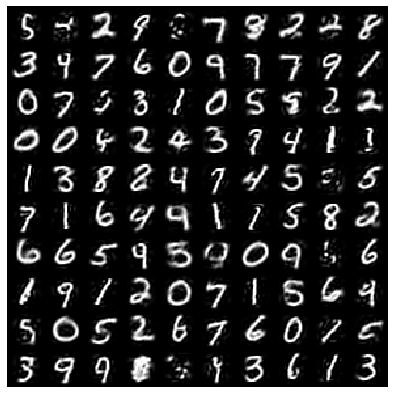

165100 -989.5703735351562
165200 -989.6008911132812
165300 -989.46337890625
165400 -989.4385375976562
165500 -989.5067749023438
165600 -989.5548706054688
165700 -989.5352172851562
165800 -989.5824584960938
165900 -989.5342407226562
166000 -989.5020751953125
166100 -989.5917358398438
166200 -989.4699096679688
166300 -989.5122680664062
166400 -989.5349731445312
166500 -989.5457763671875
166600 -989.4805297851562
166700 -989.5443725585938
166800 -989.526611328125
166900 -989.529296875
167000 -989.4974975585938
167100 -989.5039672851562
167200 -989.567626953125
167300 -989.5587158203125
167400 -989.5199584960938
167500 -989.5543212890625
167600 -989.5161743164062
167700 -989.5406494140625
167800 -989.5111083984375
167900 -989.4588012695312
168000 -989.499267578125
168100 -989.4690551757812
168200 -989.5515747070312
168300 -989.4971923828125
168400 -989.3970947265625
168500 -989.5113525390625
168600 -989.5477294921875
168700 -989.612060546875
168800 -989.4791870117188
168900 -989.5170898437

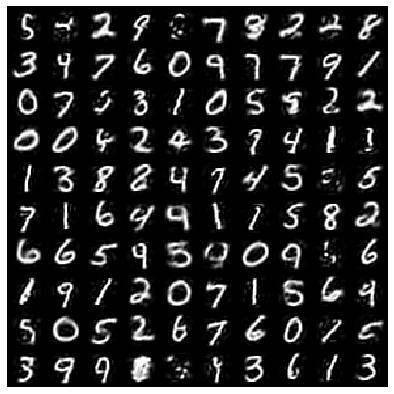

170100 -989.6069946289062
170200 -989.5652465820312
170300 -989.56591796875
170400 -989.5365600585938
170500 -989.5796508789062
170600 -989.503662109375
170700 -989.5361328125
170800 -989.4986572265625
170900 -989.5062866210938
171000 -989.484130859375
171100 -989.4808349609375
171200 -989.4950561523438
171300 -989.4556274414062
171400 -989.510498046875
171500 -989.5538330078125
171600 -989.5487670898438
171700 -989.4620361328125
171800 -989.501708984375
171900 -989.5308837890625
172000 -989.4992065429688
172100 -989.56005859375
172200 -989.548828125
172300 -989.4712524414062
172400 -989.487548828125
172500 -989.5143432617188
172600 -989.4825439453125
172700 -989.4935913085938
172800 -989.4950561523438
172900 -989.4864501953125
173000 -989.5137329101562
173100 -989.426513671875
173200 -989.4893798828125
173300 -989.5338134765625
173400 -989.4727783203125
173500 -989.4622802734375
173600 -989.4959716796875
173700 -989.5753173828125
173800 -989.4710083007812
173900 -989.4500732421875
174

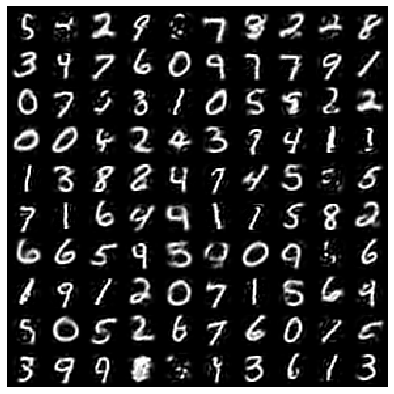

175100 -989.53955078125
175200 -989.502685546875
175300 -989.5442504882812
175400 -989.5040893554688
175500 -989.506591796875
175600 -989.4824829101562
175700 -989.50341796875
175800 -989.5836181640625
175900 -989.4785766601562
176000 -989.4845581054688
176100 -989.47314453125
176200 -989.5902099609375
176300 -989.5199584960938
176400 -989.5615844726562
176500 -989.536376953125
176600 -989.4970092773438
176700 -989.5336303710938
176800 -989.5513305664062
176900 -989.547119140625
177000 -989.490234375
177100 -989.4759521484375
177200 -989.5256958007812
177300 -989.5360107421875
177400 -989.5493774414062
177500 -989.4675903320312
177600 -989.49853515625
177700 -989.43359375
177800 -989.5907592773438
177900 -989.5796508789062
178000 -989.521240234375
178100 -989.52197265625
178200 -989.5654296875
178300 -989.4788818359375
178400 -989.5411987304688
178500 -989.4830322265625
178600 -989.4666748046875
178700 -989.4247436523438
178800 -989.5211181640625
178900 -989.4550170898438
179000 -989.5

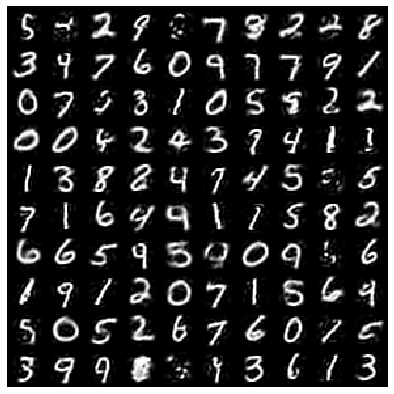

180100 -989.448974609375
180200 -989.4340209960938
180300 -989.5198974609375
180400 -989.59228515625
180500 -989.5576782226562
180600 -989.45703125
180700 -989.5484619140625
180800 -989.504150390625
180900 -989.4644775390625
181000 -989.5388793945312
181100 -989.5160522460938
181200 -989.5260009765625
181300 -989.4382934570312
181400 -989.5463256835938
181500 -989.5158081054688
181600 -989.48388671875
181700 -989.5535278320312
181800 -989.52880859375
181900 -989.5409545898438
182000 -989.4542846679688
182100 -989.482421875
182200 -989.5640258789062
182300 -989.4710083007812
182400 -989.4432983398438
182500 -989.4583129882812
182600 -989.4798583984375
182700 -989.522705078125
182800 -989.508056640625
182900 -989.481689453125
183000 -989.5059204101562
183100 -989.4979858398438
183200 -989.5194091796875
183300 -989.5297241210938
183400 -989.4140014648438
183500 -989.5784912109375
183600 -989.5074462890625
183700 -989.5247802734375
183800 -989.454833984375
183900 -989.5364990234375
184000 

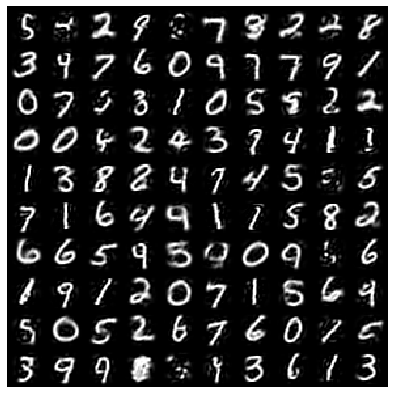

185100 -989.5836791992188
185200 -989.459716796875
185300 -989.4682006835938
185400 -989.51318359375
185500 -989.6310424804688
185600 -989.5728759765625
185700 -989.5386352539062
185800 -989.4715576171875
185900 -989.5086059570312
186000 -989.5421142578125
186100 -989.6007080078125
186200 -989.5117797851562
186300 -989.513427734375
186400 -989.529541015625
186500 -989.5126953125
186600 -989.4048461914062
186700 -989.52392578125
186800 -989.4990844726562
186900 -989.4702758789062
187000 -989.52685546875
187100 -989.5282592773438
187200 -989.4895629882812
187300 -989.5400390625
187400 -989.4739990234375
187500 -989.5028076171875
187600 -989.4397583007812
187700 -989.4727783203125
187800 -989.4945678710938
187900 -989.5069580078125
188000 -989.55029296875
188100 -989.5411987304688
188200 -989.5863647460938
188300 -989.496826171875
188400 -989.498046875
188500 -989.5203247070312
188600 -989.3947143554688
188700 -989.4900512695312
188800 -989.4725952148438
188900 -989.5033569335938
189000 -

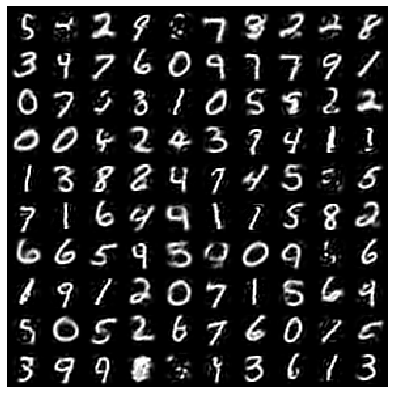

190100 -989.5498046875
190200 -989.530517578125
190300 -989.4430541992188
190400 -989.4951171875
190500 -989.5464477539062
190600 -989.54931640625
190700 -989.489990234375
190800 -989.4619750976562
190900 -989.5107421875
191000 -989.4894409179688
191100 -989.5532836914062
191200 -989.5435791015625
191300 -989.571533203125
191400 -989.5077514648438
191500 -989.50341796875
191600 -989.4650268554688
191700 -989.4719848632812
191800 -989.61083984375
191900 -989.4976196289062
192000 -989.4153442382812
192100 -989.4852294921875
192200 -989.5626831054688
192300 -989.5637817382812
192400 -989.5300903320312
192500 -989.45166015625
192600 -989.510009765625
192700 -989.49169921875
192800 -989.5204467773438
192900 -989.4597778320312
193000 -989.4813842773438
193100 -989.492431640625
193200 -989.5548706054688
193300 -989.53369140625
193400 -989.5638427734375
193500 -989.5042114257812
193600 -989.5266723632812
193700 -989.545166015625
193800 -989.5026245117188
193900 -989.5023193359375
194000 -989.5

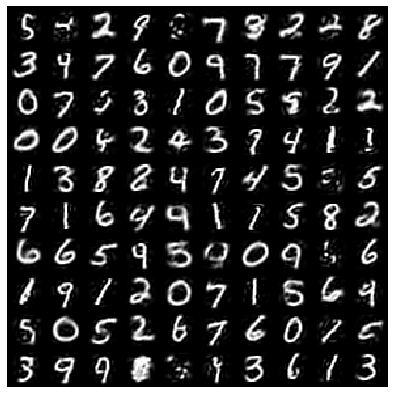

195100 -989.5845336914062
195200 -989.5542602539062
195300 -989.53369140625
195400 -989.4166259765625
195500 -989.492431640625
195600 -989.5286254882812
195700 -989.5595703125
195800 -989.4876708984375
195900 -989.4944458007812
196000 -989.610595703125
196100 -989.499755859375
196200 -989.497802734375
196300 -989.5343017578125
196400 -989.5433959960938
196500 -989.463623046875
196600 -989.5858764648438
196700 -989.5454711914062
196800 -989.5291137695312
196900 -989.474365234375
197000 -989.5759887695312
197100 -989.4839477539062
197200 -989.501953125
197300 -989.5278930664062
197400 -989.529296875
197500 -989.531982421875
197600 -989.5291137695312
197700 -989.5339965820312
197800 -989.51904296875
197900 -989.49365234375
198000 -989.4713745117188
198100 -989.5653076171875
198200 -989.5381469726562
198300 -989.5232543945312
198400 -989.4553833007812
198500 -989.4833374023438
198600 -989.5435180664062
198700 -989.4779663085938
198800 -989.5321655273438
198900 -989.5404663085938
199000 -98

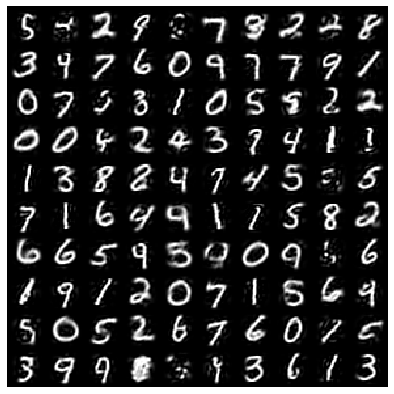

In [346]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid

def adaptive_estimation(v_t, beta, square_term, i):
    v_t = beta*v_t + (1-beta)*square_term.detach()
    return v_t, (v_t/(1-beta**i))

torch.cuda.set_device(0)

def gauss(A,B,var):
    return torch.exp(-((A.unsqueeze(1) - B.unsqueeze(0))**2).mean(2)/(2*var))

torch.manual_seed(1)
np.random.seed(1)

dim = 20
data_dim = 784*1

D = encoder(input_dim = 100, out_dim = data_dim).cuda()

optimizer_D = optim.Adam([
      {'params': D.parameters(), 'lr': .0005,'betas': (0.5, 0.9)},
   ])

# E = encoder(input_dim = data_dim, out_dim = data_dim).cuda()

# optimizer_E = optim.Adam([
#       {'params': E.parameters(), 'lr': 0.0001,'betas': (0.5, 0.9)},
#    ])


elbo_curve = []
pdf_curve = []
error_curve = []

bound_curve = []
eig_list = []

est_numerator = 0
est_denominator = 0
    
for i in range(1, 200001):
    
    b1 = np.random.choice(train_data.shape[0], 10000)
    batch_data = torch.from_numpy(train_data[b1]).float().cuda()
    bs = batch_data.shape[0]
        
    encoded = torch.eye((100)).float().cuda()
    decoded = D(encoded)
        
    A = batch_data
    B = decoded
    G = A @ B.T                           # (N, M)
    na = (A * A).sum(dim=1, keepdim=True) # (N, 1) = ||A_i||^2
    nb = (B * B).sum(dim=1, keepdim=True).T  # (1, M) = ||B_j||^2
    d = A.shape[1]
    gram_matrix = (na + nb - 2 * G) / d
    gram_matrix = torch.exp(-gram_matrix)
#     gram_matrix = torch.cat((torch.exp(-gram_matrix/20), torch.exp(-gram_matrix/2), torch.exp(-gram_matrix/.2), torch.exp(-gram_matrix/.02)), 0)
#     gram_matrix = (-gram_matrix)

#     gram_matrix = -batch_data@decoded.T/batch_data.shape[1]

#     P = batch_data@decoded.T/batch_data.shape[1]
#     RF = batch_data@batch_data.T/batch_data.shape[1]
#     RG = decoded@decoded.T/decoded.shape[1]
    
#     E1,V1 = torch.linalg.eigh(RF)
#     E2,V2 = torch.linalg.eigh(RG)
#     RF_NORM = V1@torch.diag(E1**(-1/2))@V1.T
#     RG_NORM = V2@torch.diag(E2**(-1/2))@V2.T

#     gram_matrix = P@RG_NORM    

    
#     gram_matrix = -((batch_data.unsqueeze(1) - decoded.unsqueeze(0))**2).mean(-1)

    U, S, V = torch.svd(gram_matrix)
    cc = -(S).sum()
    cc.backward()

    
    pdf_curve.append(cc.item())
    
    optimizer_D.step()
    optimizer_D.zero_grad()

    if i % 100 == 0:

        print(i, cc.item())
            
        if i % 5000 == 0:
            
            plt.figure(figsize=(7,7)) 
            save_image(decoded[:].reshape(-1, 1, 28, 28)[:100], 'img1.png', normalize=True, nrow=10, padding=1) 
            img = plt.imread('img1.png') 
            plt.imshow(img) 
            plt.axis('off') 
            plt.show() 

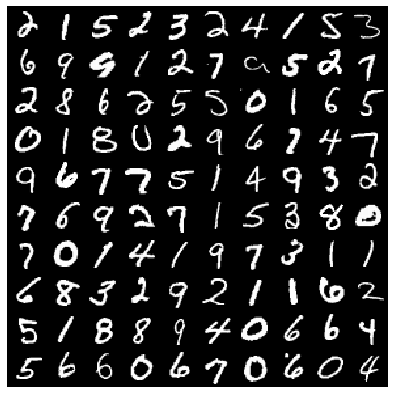

In [315]:

plt.figure(figsize=(7,7)) 
save_image(batch_data[:].reshape(-1, 1, 28, 28)[:100], 'img1.png', normalize=True, nrow=10, padding=1) 
img = plt.imread('img1.png') 
plt.imshow(img) 
plt.axis('off') 
plt.show() 

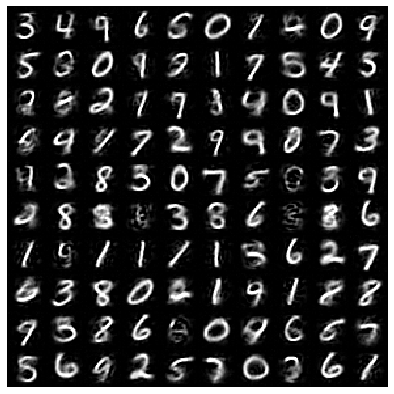

In [126]:
plt.figure(figsize=(7,7)) 
save_image(torch.clip(decoded, 0, 1)[:].reshape(-1, 1, 28, 28)[:100], 'img1.png', normalize=True, nrow=10, padding=1) 
img = plt.imread('img1.png') 
plt.imshow(img) 
plt.axis('off') 
plt.show() 